In [87]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 5)

import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import roc_curve, auc

Populating the interactive namespace from numpy and matplotlib


In [2]:
dftrain = pd.read_csv('./data/txTripletsCounts.txt',
                      header=None,
                      index_col=None,
                      sep=' ',
                      names=['sender','receiver','transaction'])
dftrain['transaction'].describe()

count    3.348026e+06
mean     4.725741e+00
std      1.284948e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.163900e+04
Name: transaction, dtype: float64

In [103]:
print len(dftrain['transaction'])
print (dftrain['transaction'] == 1).sum()
print (dftrain['transaction'] == 2).sum()
print (dftrain['transaction'] < 1).sum()
print 2257813 / 3348026.
print 463660/ 3348026.
print 3348026. / 444075

3348026
2257813
463660
0
0.674371405718
0.138487574469
7.53932556438


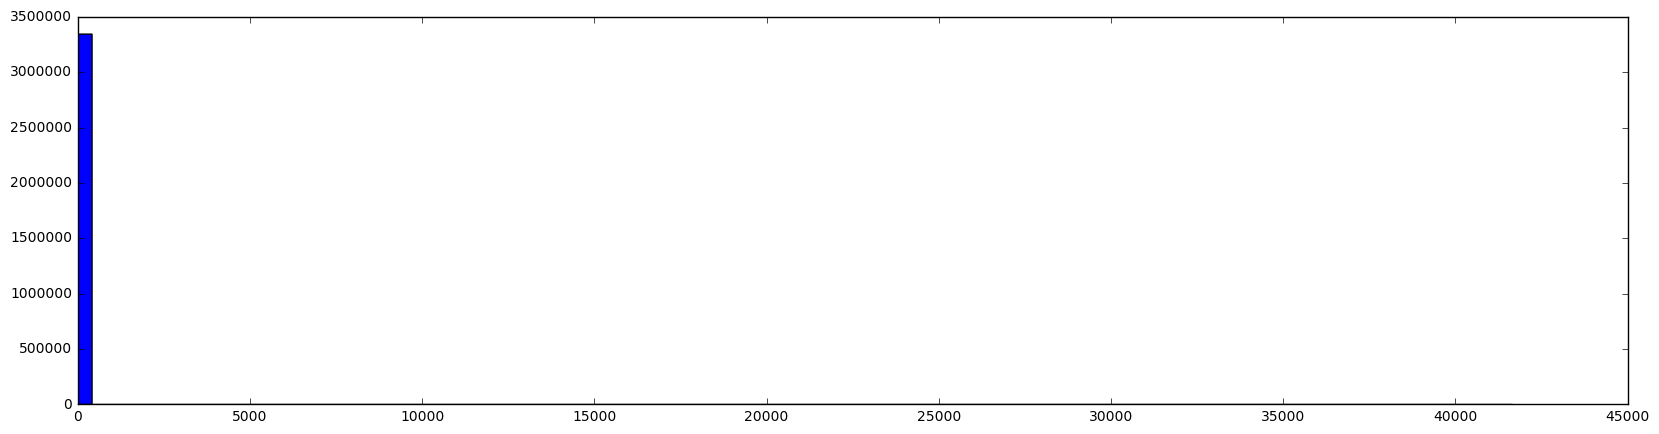

In [3]:
plt.hist(dftrain['transaction'].values,100);

In [4]:
n_sender = dftrain['sender'].unique().size
n_receiver = dftrain['receiver'].unique().size
n_nonmissing = dftrain['transaction'].count()
sparsity = 1 - n_nonmissing*1.0/ (n_sender * n_receiver)

In [5]:
print "n_sender=%i" % n_sender
print "n_receiver=%i" % n_receiver
print "n_nonmissing=%i"% n_nonmissing
print "sparsity=%2.6f"% sparsity

n_sender=443652
n_receiver=439602
n_nonmissing=3348026
sparsity=0.999983


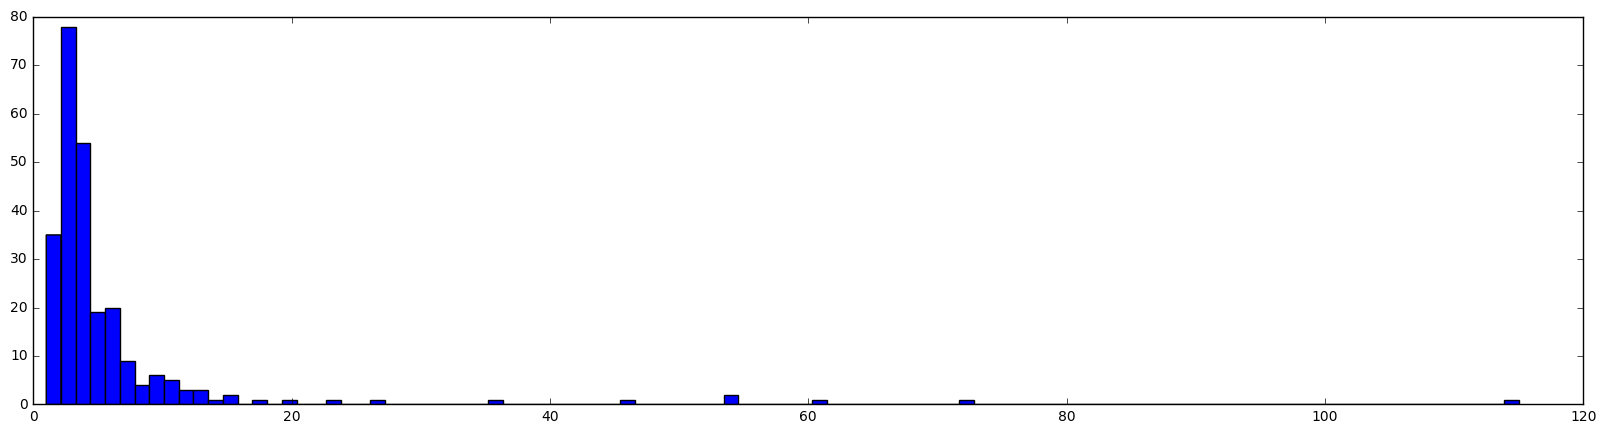

In [11]:
random_senders = np.random.choice(dftrain['sender'].unique(),250)
s2c = pd.Series({s:dftrain.ix[dftrain['sender']==s,'transaction'].sum() for s in random_senders})
plt.hist(s2c,100);

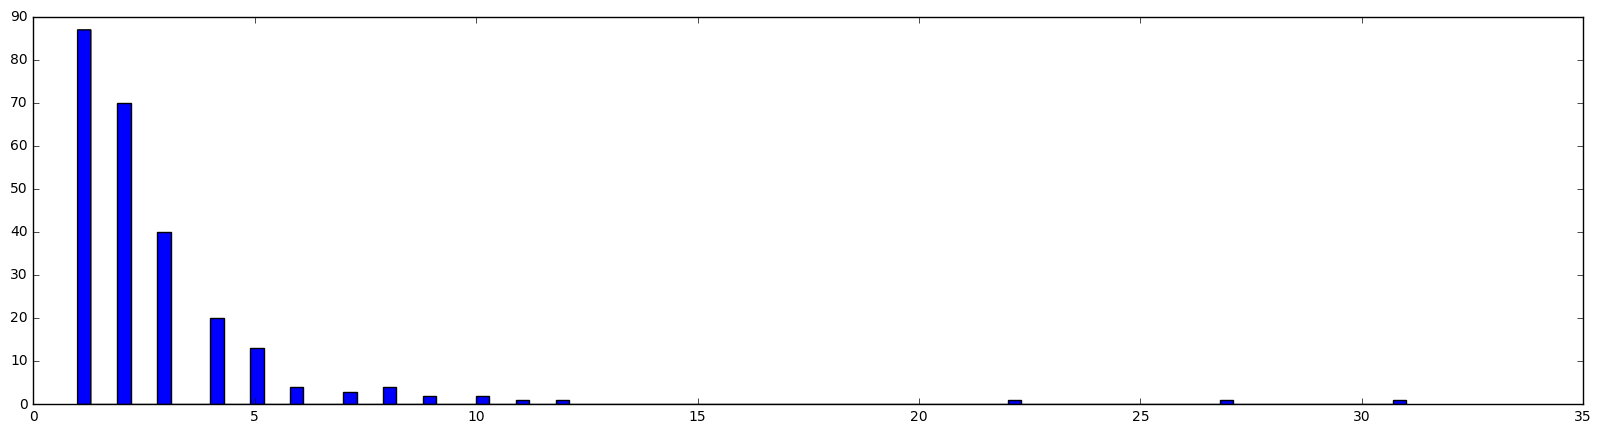

In [13]:
s2t = pd.Series({s:len(dftrain.ix[dftrain['sender']==s]) for s in random_senders})
plt.hist(s2t,100);

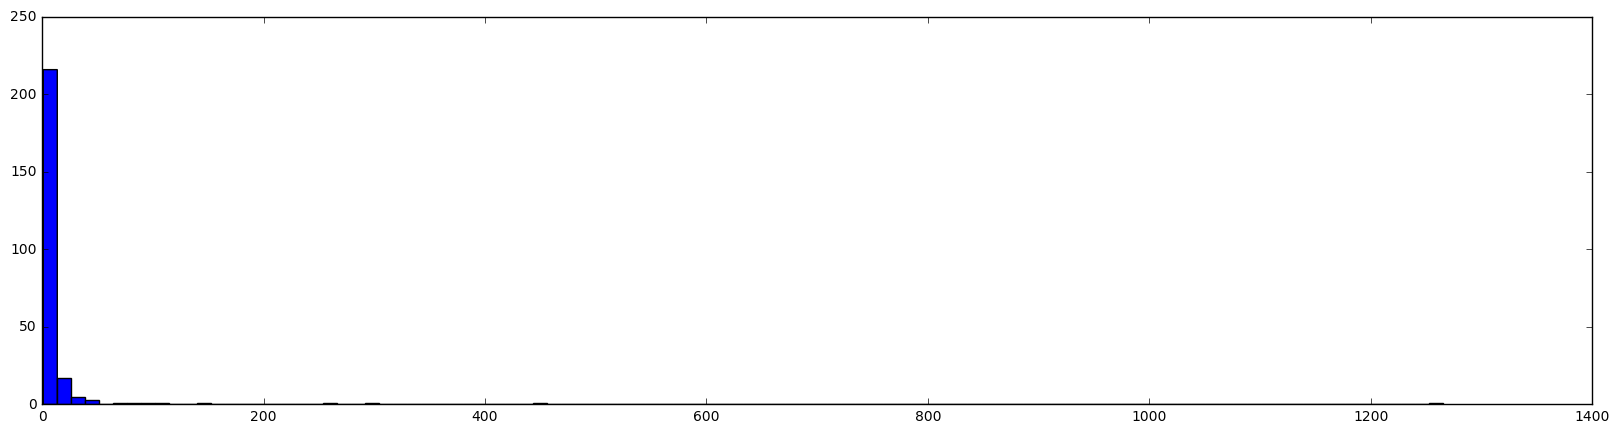

In [14]:
random_receivers = np.random.choice(dftrain['receiver'].unique(),250)
r2c = pd.Series({r:dftrain.ix[dftrain['receiver']==r,'transaction'].sum() for r in random_receivers})
plt.hist(r2c,100);

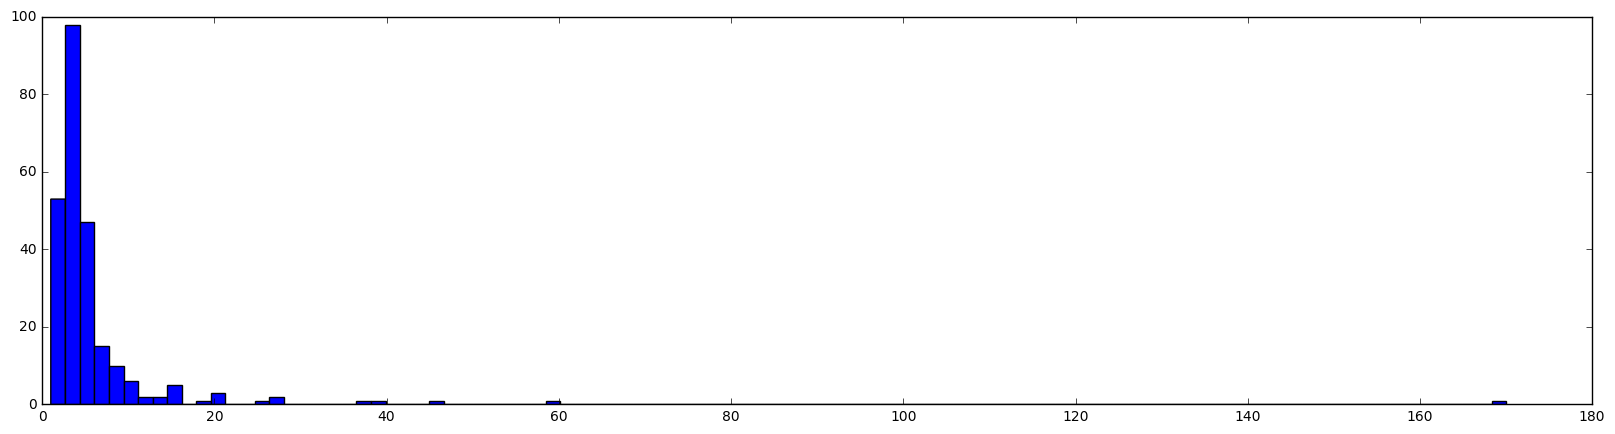

In [15]:
r2t = pd.Series({r:len(dftrain.ix[dftrain['receiver']==r]) for r in random_receivers})
plt.hist(r2t,100);

# Modeling Missing Entries

Missing at random assumption:
Essentialy, we assume that there is a transaction between every sender and receiver. We are only revealed a subset of these transactions.

                          X_{ij} ~ P(X_{ij}|Theta) P(Theta)

Missing at non-random assumption:
There exist a latent structure that determines if an entry is missing. If it is not missing, then the transaction count is given by a response model.

                          X_{ij} ~ P(X_{ij}|Theta, I_{ij}) P(Theta) P(I_{ij} | Phi) P(Phi)

How comprehensive is the dataset?
There might still be a financial transaction between the sender and receiver but in a different medium (bank transfer, checks etc.). This surface the question how confident we are about the missingness of an entry. The truth lies somewhere between the missing-at-random and missing-at-non-random assumptions.

# Models

If making missing-at-non-random assumption, choose the distance-metric / underlying-response-distribution carefully. It should have a support at zero. Some examples are bernoulli, poisson, binomial, negative binomial etc.

## Mixture Models 

Clustering across senders

Clustering across receivers

Mixture Models

Topic Models

## Matrix Factorization

Matrix factorization assumes

                        X_{ij} = \Sum_{k} U_{ik} V_{jk}
                        
where k << #rows and k << #columns

-PCA : Principal Component Analysis

-PMF : Probabilistic Matrix Factorization

-NMF : Non-negative Matrix Factorization

-PF : Poisson Factorization

-HPF : Hierarchical Poisson Factorization

Many of the colloborative filtering methods are based on matrix factorization models.

In colloborative filtering literature, models making missing-at-non-random assumption are sometimes called implicit feedback models.

## Graph Based Methods

Choosing the similarity function is important

You can use neighbors for prediction 

Pagerank

# Metrics

ROC curve and AUC

Recall@k

Mean Average Precision@k

In [88]:
dftest = pd.read_csv('./data/testTriplets.txt',
                     header=None,
                     index_col=None,
                     sep=' ',
                     names=['sender','receiver','transaction'])
dim = max((dftrain['sender'].max(),
           dftrain['receiver'].max(),
           dftest['sender'].max(),
           dftest['receiver'].max()))

dim += 1
train_csr = csr_matrix((dftrain['transaction'],(dftrain['sender'],dftrain['receiver'])),
                       shape=(dim,dim),
                       dtype=float)

# binarize matrix
train_csr[train_csr != 0] = 1

In [90]:
dftrain['sender'].max()

444074

In [11]:
u, s, vt = svds(train_csr, k=11, tol=1e-10, which = 'LM')

Area under the ROC curve : 0.735229


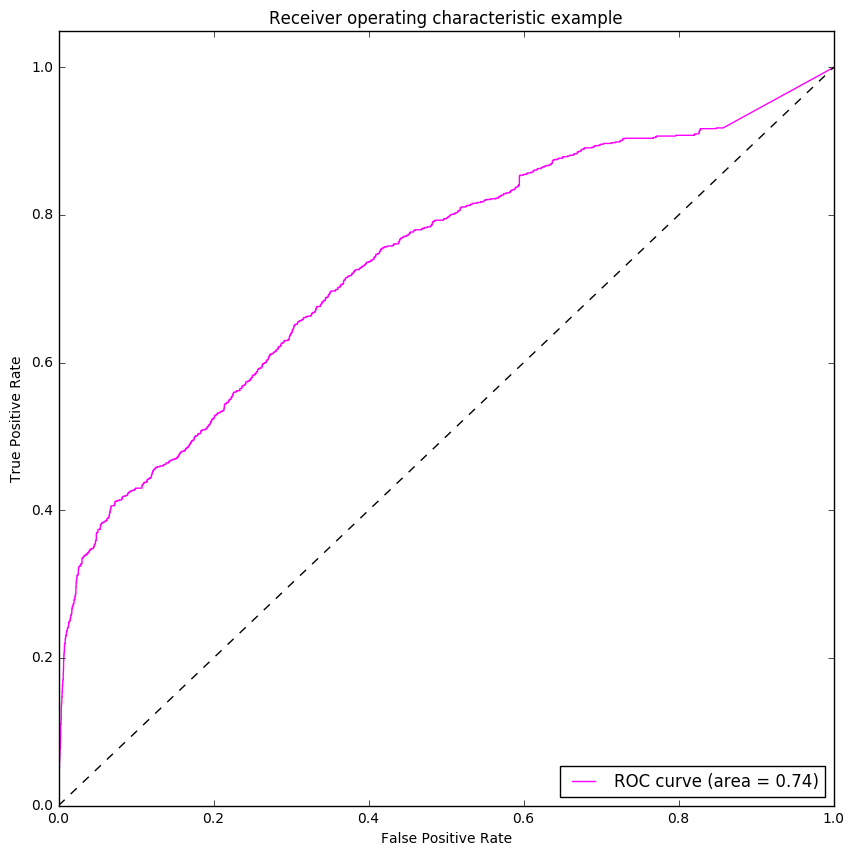

In [18]:
pred = [np.sum(u[row['sender'],:] * s * vt[:,row['receiver']]) 
        for index,row in dftest.iterrows()]

values = []
for v in pred:
    if v < 0:
        values.append(0.0)
    elif v > 1:
        values.append(1.0)
    else:
        values.append(v)
pred = values

label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

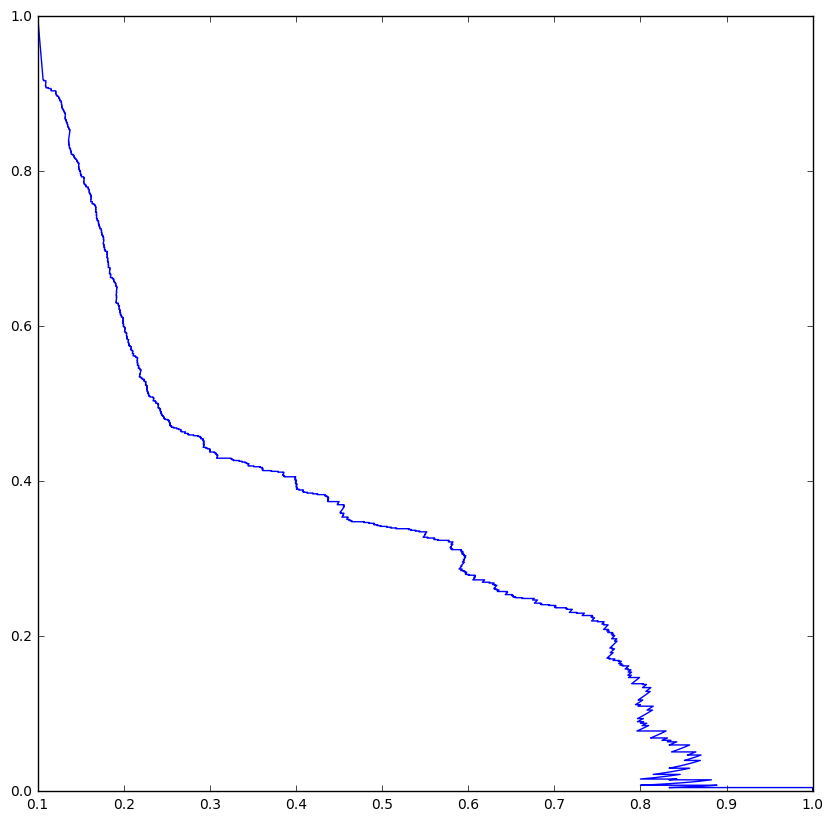

In [21]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    label, pred)
plt.plot(precision, recall)
plt.show()

(-0.2, 0.1)

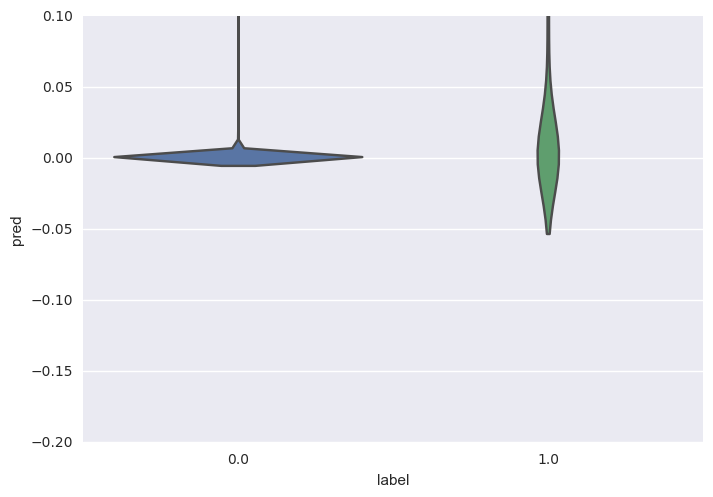

In [37]:
import seaborn as sns
import pandas as pd
data = numpy.array([(x, y) for (x, y) in zip(pred, label)])
data = pd.DataFrame(data, columns=["pred", "label"])
#sns.swarmplot(x="label", y="pred", data=data);
#plt.show()
sns.violinplot(x="label", y="pred", data=data, inner=None)
ax = plt.gca()
ax.set_ylim(-0.2, 0.1)

(-0.2, 0.1)

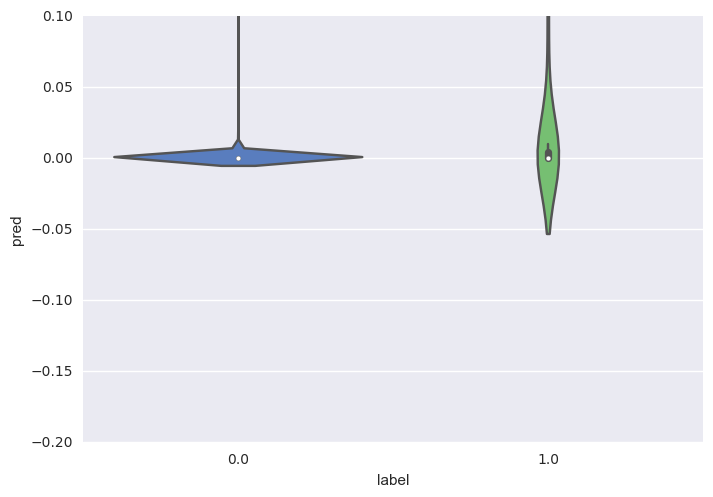

In [41]:
ax = sns.violinplot(x="label", y="pred",
                    data=data, palette="muted", split=True)
ax = plt.gca()
ax.set_ylim(-0.2, 0.1)

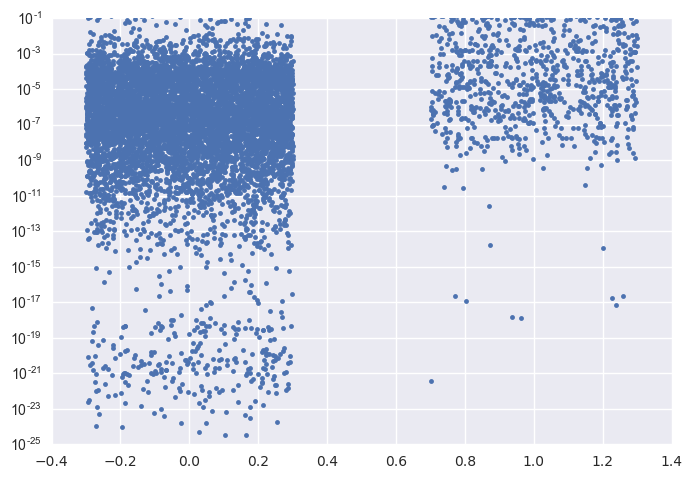

In [54]:
def random_perturb(data):
    data = np.array(data)
    return np.array(data) + np.random.uniform(low=-0.3, high=0.3, size=data.shape)

plt.plot(random_perturb(label), pred, '.')
ax = plt.gca()
ax.set_yscale('log')
ax.set_ylim([1e-25, 1e-1])

plt.show()

In [2]:
svd = TruncatedSVD(n_components=11)
svd.fit(train_csr)

NameError: name 'TruncatedSVD' is not defined

In [1]:
svd.inverse_transform(svd.transform(train_csr))

NameError: name 'svd' is not defined